# S-Curve Scan with Qinj

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from fnmatch import fnmatch
import hist
from hist import Hist

In [9]:
QInjEns = [10]
thresholds = np.arange(241,600,5)
row_list = [3]
col_list = [3]
scan_list = list(zip(col_list, row_list))

In [10]:
root = '../ETROC-Data'
file_pattern = "*translated*.dat"
hitmap_full_Scurve = {row:{col:{q:{thr:0 for thr in thresholds} for q in QInjEns} for col in range(16)} for row in range(16)}
for index, row, col in zip((range(len(row_list))), row_list, col_list):
    for QInj in (QInjEns):
        for DAC in (thresholds):
            print(f'Pixel {col},{row} - {QInj} fC - DAC {DAC}')
            path_pattern = f"*E2_testing_VRef_SCurve_Pixel_C{col}_R{row}_QInj_{QInj}_Threshold_{DAC}"
            file_list = []
            for path, subdirs, files in os.walk(root):
                if not fnmatch(path, path_pattern): continue
                for name in files:
                    pass
                    if fnmatch(name, file_pattern):
                        file_list.append(os.path.join(path, name))
                        print(file_list[-1])
            current_bcid = -1
            previous_bcid = -1
            total_files = len(file_list)
            for file_index, file_name in enumerate(file_list):
                print(f"{file_index+1}/{total_files}")
                with open(file_name) as infile:
                    for line in infile:
                        text_list = line.split()
                        if(text_list[2]=="HEADER"): current_bcid = int(text_list[8])
                        elif(text_list[2]=="TRAILER"): previous_bcid = current_bcid
                        if(previous_bcid==-1 or (current_bcid-previous_bcid==68 if current_bcid>=previous_bcid else current_bcid+3564-previous_bcid==68)): continue
                        if text_list[2]!="DATA": continue
                        c_running = int(text_list[6])
                        r_running = int(text_list[8])
                        hitmap_full_Scurve[r_running][c_running][QInj][DAC] += 1 

Pixel 3,3 - 10 fC - DAC 241
../ETROC-Data/2023-06-07_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C3_R3_QInj_10_Threshold_241/TDC_Data_translated_0.dat
1/1
Pixel 3,3 - 10 fC - DAC 246
../ETROC-Data/2023-06-07_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C3_R3_QInj_10_Threshold_246/TDC_Data_translated_0.dat
1/1
Pixel 3,3 - 10 fC - DAC 251
../ETROC-Data/2023-06-07_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C3_R3_QInj_10_Threshold_251/TDC_Data_translated_2.dat
../ETROC-Data/2023-06-07_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C3_R3_QInj_10_Threshold_251/TDC_Data_translated_1.dat
../ETROC-Data/2023-06-07_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C3_R3_QInj_10_Threshold_251/TDC_Data_translated_0.dat
1/3
2/3
3/3
Pixel 3,3 - 10 fC - DAC 256
../ETROC-Data/2023-06-07_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C3_R3_QInj_10_Threshold_256/TDC_Data_translated_0.dat
1/1
Pixel 3,3 - 10 fC - DAC 261
../ETROC-Data/2023-06-07_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C

In [12]:
def turning_points(array):
    ''' turning_points(array) -> min_indices, max_indices
    Finds the turning points within an 1D array and returns the indices of the minimum and 
    maximum turning points in two separate lists.

    Adapted from https://stackoverflow.com/questions/19936033/finding-turning-points-of-an-array-in-python
    '''
    idx_max, idx_min = [], []
    if (len(array) < 3): 
        return idx_min, idx_max

    NEUTRAL, RISING, FALLING = range(3)
    def get_state(a, b):
        if a < b: return RISING
        if a > b: return FALLING
        return NEUTRAL

    ps = get_state(array[0], array[1])
    begin = 1
    for i in range(2, len(array)):
        s = get_state(array[i - 1], array[i])
        if s != NEUTRAL:
            if ps != NEUTRAL and ps != s:
                if s == FALLING: 
                    idx_max.append((begin + i - 1) // 2)
                else:
                    idx_min.append((begin + i - 1) // 2)
            begin = i
            ps = s
    return idx_min, idx_max

In [22]:
idx_min, idx_max = turning_points(list(hitmap_full_Scurve[3][3][10].values()))

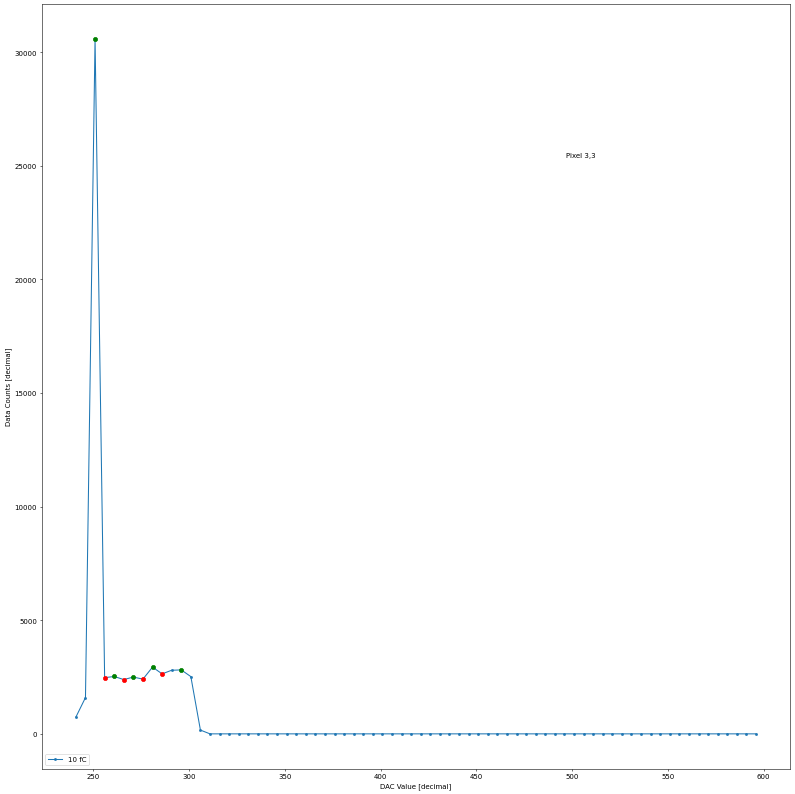

In [27]:
fig = plt.figure(dpi=50, figsize=(16,16))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        # ax0.axvline(BL_map_THCal[row][col], color='r', label="THCal BL")
        # ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', label="THCal NW")
        # ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k')
        for QInj in QInjEns:
            ax0.plot(thresholds, hitmap_full_Scurve[row][col][QInj].values(), '.-', label=f"{QInj} fC")
        ax0.set_xlabel("DAC Value [decimal]")
        ax0.set_ylabel("Data Counts [decimal]")
        ax0.text(0.7, 0.8, f"Pixel {row},{col}", transform=ax0.transAxes)
        ax0.plot(thresholds[idx_min], np.array(list(hitmap_full_Scurve[row][col][QInj].values()))[idx_min], 'ro')
        ax0.plot(thresholds[idx_max], np.array(list(hitmap_full_Scurve[row][col][QInj].values()))[idx_max], 'go')
        plt.legend(loc="lower left")
plt.tight_layout()
plt.show()